In [14]:
import uproot
import awkward as ak
import numpy as np
import vector
import math
from tqdm import tqdm
from ipywidgets import interact, FloatSlider

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.stats import norm


%matplotlib widget


e_mass = 511
r_e = 2.817e-15


def process_root_file(file_location):
   
    file = uproot.open(file_location)
    #tree = file["filteredPhoton"]
    tree = file["Hits"]
    tree_l = file['Lost_compt']
    branches = ["eventID", "processName", "rsectorID","edep"]
    # branches = ["eventID","rsectorID", "processName", "edep", "posX", "posY", "posZ", 
    #         "sourcePosX", "sourcePosY", "sourcePosZ"]
    data = tree.arrays(branches,library="ak")
    data_l = tree_l.arrays(branches,library="ak")

    print(f"Number of events in the data: {len(np.unique(ak.to_numpy(data['eventID'])))}")

    meta = {}
    if "Metadata" in file:
        metadata_tree = file["Metadata"]
        meta_arrays = metadata_tree.arrays(library="np")
        meta = {k: v[0] if v.size == 1 else v for k, v in meta_arrays.items()}
        print("✅ Metadata loaded.")
    else:
        print("⚠️ No Metadata tree found.")

    return data, data_l, meta


def klein_nishina(theta_degrees, E_i):
    # Convert degrees to radians for computation
    theta_radians = np.radians(theta_degrees)
    
    # Compute scattered photon energy
    E_prime = E_i / (1 + (E_i / e_mass) * (1 - np.cos(theta_radians)))
    
    # Compute differential cross-section
    differential_cross_section = 0.5 * r_e**2 * (E_prime / E_i)**2 * (
        (E_prime / E_i) + (E_i / E_prime) - np.sin(theta_radians)**2
    )
    
    return differential_cross_section



In [15]:
data,data_lost,meta = process_root_file('root_files/beam_9cm/filtered/Fl_1_phi_511keV_2MBq.root')
#meta['totFirstCompt']
meta['sourceEnergy']

Number of events in the data: 795463
✅ Metadata loaded.


np.int64(511)

In [16]:
E_i = meta['sourceEnergy']
compt_shoulder = 2/(2 + e_mass/E_i) * E_i




edep = data['edep'][::2] * 1000
C_beta   = (E_i - edep*(1 + e_mass/E_i))/(E_i-edep)
beta       = np.degrees(np.acos(C_beta))
n_total_compton = len(beta)


edep_l = data_lost['edep'][:] * 1000

C_beta_l    = (E_i - edep_l*(1 + e_mass/E_i))/(E_i-edep_l)
beta_l       = np.degrees(np.acos(C_beta_l))
n_lost_compton = len(beta_l)



groups = ak.unflatten(data, ak.run_lengths(data["eventID"]))
processName = groups["processName"]
rsectorID   = groups["rsectorID"]
edep        = groups['edep']
data = ak.flatten(groups)




# processName = groups["processName"]
# rsectorID   = groups["rsectorID"]
# edep        = groups['edep']
# data = ak.flatten(groups)

same_sector = (rsectorID[:, 0] == rsectorID[:, 1])
f_p = (processName[:,1] == 'phot') & same_sector 
f_c = (processName[:,1] == 'compt') & same_sector 
f_r = (processName[:,1] == 'Rayl') & same_sector 

print(n_total_compton+ n_lost_compton)



955773


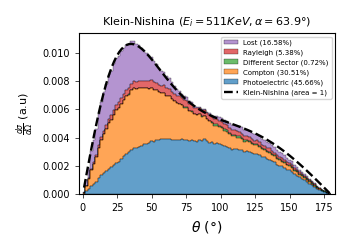

In [17]:

th_p = beta[f_p]
th_lost = beta_l
th_c = beta[f_c]
th_r = beta[f_r]
th_diffS =beta[~same_sector]


# 1. Photon energy from metadata
E_i = meta['sourceEnergy'] # Ensure scalar

# 2. Define binning
bins = np.linspace(0, 180, 100)
bin_width = bins[1] - bins[0]
bin_centers = (bins[:-1] + bins[1:]) / 2

# 3. Compute target area for each component
#tot_first_compt = meta['totFirstCompt']
tot_first_compt = meta['totFirstCompt']
area_p      = len(th_p) / tot_first_compt
area_lost   = len(th_lost) / tot_first_compt
area_c      = len(th_c) / tot_first_compt
area_r      = len(th_r) / tot_first_compt
area_diffS  = len(th_diffS) / tot_first_compt  # <-- new component

# 4. Assign weights (area-per-bin normalization)
weights_p      = np.full_like(th_p,      fill_value=(area_p / len(th_p)) / bin_width)
weights_lost   = np.full_like(th_lost,   fill_value=(area_lost / len(th_lost)) / bin_width)
weights_c      = np.full_like(th_c,      fill_value=(area_c / len(th_c)) / bin_width)
weights_r      = np.full_like(th_r,      fill_value=(area_r / len(th_r)) / bin_width)
weights_diffS  = np.full_like(th_diffS,  fill_value=(area_diffS / len(th_diffS)) / bin_width)

# 5. Plot stacked histogram
plt.clf()
plt.figure(figsize=(3.5, 2.5))
plt.hist(
    [th_p, th_c, th_diffS, th_r, th_lost],
    bins=bins,
    weights=[weights_p, weights_c, weights_diffS, weights_r, weights_lost],
    stacked=True,
    label=[
        f"Photoelectric ({area_p*100:.2f}%)",
        f"Compton ({area_c*100:.2f}%)",
        f"Different Sector ({area_diffS*100:.2f}%)",
        f"Rayleigh ({area_r*100:.2f}%)",
        f"Lost ({area_lost*100:.2f}%)"
    ],
    alpha=0.7,
    histtype='stepfilled',
    edgecolor='black',
    linewidth=0.3 
)

# 6. Klein-Nishina prediction (area = 1)
klein_nishina_per_deg = klein_nishina(bin_centers, E_i)
klein_nishina_per_deg = ak.to_numpy(klein_nishina_per_deg)
klein_nishina_per_deg *= 2 * np.pi * np.sin(np.radians(bin_centers))
klein_nishina_per_deg /= np.trapezoid(klein_nishina_per_deg, bin_centers)

# 7. Plot Klein-Nishina
plt.plot(
    bin_centers,
    klein_nishina_per_deg,
    label='Klein-Nishina (area = 1)',
    lw=1.7,
    color='black',
    linestyle='--'
)

# 8. Final plot styling
plt.xlabel(r'$\theta$ (°)')
plt.ylabel(r'$\frac{d\sigma}{d\Omega}$ (a.u)',fontsize = 8 )
plt.title(rf"Klein-Nishina ($E_i ={E_i}KeV, \alpha = 63.9°$)", fontsize = 8)
plt.xlim(-3, 183)
plt.tick_params(axis='both', labelsize=7, length=3, width=0.5)
plt.legend(fontsize=5, loc='upper right')
#plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:

# 1. Photon energy from metadata
E_i = meta['sourceEnergy'] # Ensure scalar

# 2. Define binning
bins = np.linspace(0, 180, 100)
bin_width = bins[1] - bins[0]
bin_centers = (bins[:-1] + bins[1:]) / 2




# th_p = beta[f_p]
# th_lost = beta_l
# th_c = beta[f_c]
# th_r = beta[f_r]
# th_diffS =beta[~same_sector]



# tot_first_compt = meta['totFirstCompt']
# area_p      = len(th_p) / tot_first_compt
# area_lost   = len(th_lost) / tot_first_compt
# area_c      = len(th_c) / tot_first_compt
# area_r      = len(th_r) / tot_first_compt
# area_diffS  = len(th_diffS) / tot_first_compt  


# weights_p      = np.full_like(th_p,      fill_value=(area_p / len(th_p)) / bin_width)
# weights_lost   = np.full_like(th_lost,   fill_value=(area_lost / len(th_lost)) / bin_width)
# weights_c      = np.full_like(th_c,      fill_value=(area_c / len(th_c)) / bin_width)
# weights_r      = np.full_like(th_r,      fill_value=(area_r / len(th_r)) / bin_width)
# weights_diffS  = np.full_like(th_diffS,  fill_value=(area_diffS / len(th_diffS)) / bin_width)





th_p2 = beta[f_p]
th_lost2 = beta_l
th_c2 = beta[f_c]
th_r2 = beta[f_r]
th_diffS2 =beta[~same_sector]


tot_first_compt = meta['totFirstCompt']
area_p2      = len(th_p) / tot_first_compt
area_lost2   = len(th_lost) / tot_first_compt
area_c2      = len(th_c) / tot_first_compt
area_r2      = len(th_r) / tot_first_compt
area_diffS2  = len(th_diffS) / tot_first_compt  

weights_p      = np.full_like(th_p,      fill_value=(area_p / len(th_p_2)) / bin_width)
weights_lost   = np.full_like(th_lost,   fill_value=(area_lost / len(th_lost_2)) / bin_width)
weights_c      = np.full_like(th_c,      fill_value=(area_c / len(th_c_2)) / bin_width)
weights_r      = np.full_like(th_r,      fill_value=(area_r / len(th_r_2)) / bin_width)
weights_diffS  = np.full_like(th_diffS,  fill_value=(area_diffS / len(th_diffS_2)) / bin_width)

NameError: name 'th_p_2' is not defined

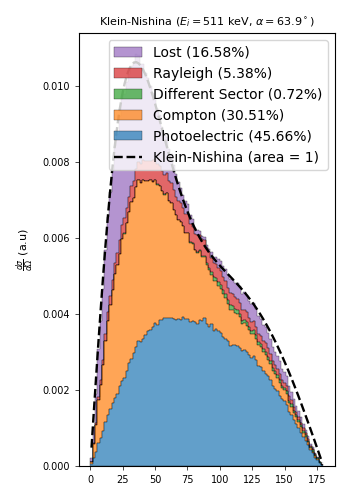

In [11]:

# 1. Create the figure and subplots
fig, ax1 = plt.subplots(1, 1, figsize=(3.5, 5), sharex=True)
plt.subplots_adjust(hspace=0.3)  # Adjust vertical spacing

# 2. First histogram (top)
ax1.hist(
    [th_p, th_c, th_diffS, th_r, th_lost],
    bins=bins,
    weights=[weights_p, weights_c, weights_diffS, weights_r, weights_lost],
    stacked=True,
    label=[
        f"Photoelectric ({area_p*100:.2f}%)",
        f"Compton ({area_c*100:.2f}%)",
        f"Different Sector ({area_diffS*100:.2f}%)",
        f"Rayleigh ({area_r*100:.2f}%)",
        f"Lost ({area_lost*100:.2f}%)"
    ],
    alpha=0.7,
    histtype='stepfilled',
    edgecolor='black',
    linewidth=0.3,
)

ax1.plot(
    bin_centers,
    klein_nishina_per_deg,
    label='Klein-Nishina (area = 1)',
    lw=1.7,
    color='black',
    linestyle='--'
)

ax1.set_ylabel(r'$\frac{d\sigma}{d\Omega}$ (a.u)', fontsize=8)
ax1.set_title(rf"Klein-Nishina ($E_i = {E_i}$ keV, $\alpha = 63.9^\circ$)", fontsize=8)
ax1.tick_params(axis='both', labelsize=7, length=3, width=0.5)
ax1.legend(fontsize=10, loc='upper right')



# 4. Final layout
plt.tight_layout()
plt.show()